In [5]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from jax import random 
import iqpopt as iqp
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
import jax
import jax.numpy as jnp

### Sacar Dataset

In [2]:
from jax import random
from datasets.mnist import MNISTDataset
from src.autoencoders.simple_vae import model
from src.utils.autoencoder_trainer import AutoencoderTrainer
from src.utils.autoencoder_manager import  restore_model_state

batch_size = 128
latent_dim = 16
rng = random.PRNGKey(0)
binary_vae = model(latents=latent_dim)
input_shape = (batch_size, 14, 14, 1)
learning_rate = 3e-5

train_dataset = MNISTDataset(split='train', batch_size=batch_size, image_size=(14, 14)).load()
test_dataset = MNISTDataset(split='test', batch_size=batch_size, image_size=(14, 14)).load()
trainer = AutoencoderTrainer(binary_vae, learning_rate, rng, input_shape)

state = restore_model_state('weights/binary_vae_250epoch_3e-4lr_16latentdim/checkpoint_250', trainer.state)
params = state.params

Checkpoint restored from directory 'c:\Users\marcos.arroyo\Documents\GitHub\Latent-IQP\weights\binary_vae_250epoch_3e-4lr_16latentdim\checkpoint_250'.


c:\Users\marcos.arroyo\Desktop\Hello\entorno312\Lib\site-packages\orbax\checkpoint\_src\serialization\type_handlers.py:1250: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [3]:
from src.utils.autoencoder_manager import get_latent_dataset, generate_from_latent

l_data, labels = get_latent_dataset(binary_vae, params, train_dataset, batch_size )

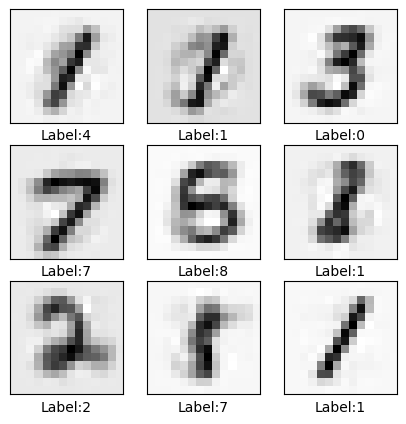

In [13]:
j = 1
plt.figure(figsize=[5, 5])
for i in range(9):
    ax = plt.subplot(3, 3, j)
    j += 1
    generated = generate_from_latent(binary_vae, params, l_data[0][i], (14,14,1), False)
    plt.imshow(generated, cmap="gray_r")
    plt.xlabel(f'Label:{labels[0][i]}')
    plt.xticks([])
    plt.yticks([])

In [25]:
#Applanar data set
plano = []
labels_plano = []
for k in range(100):
    for d in range(128):
        plano.append(l_data[k][d])
        labels_plano.append(labels[k][d])
        

# Construir circuito IQP y entrenar con el dataset


In [82]:
gates = []

n_qubits = 16
depth = 30

for d in range(depth):
    for k in range(n_qubits):
        gates.append([[k]])
        for j in range(k+1,n_qubits):
            gates.append([[k,j]])


circ = iqp.IqpSimulator(n_qubits,gates,device ='lightning.qubit')

0.9428090415820635


Training Progress: 100%|██████████| 700/700 [12:17<00:00,  1.05s/it, loss=0.000705, elapsed time=1.11, total time=738] 


Training has not converged after 700 steps


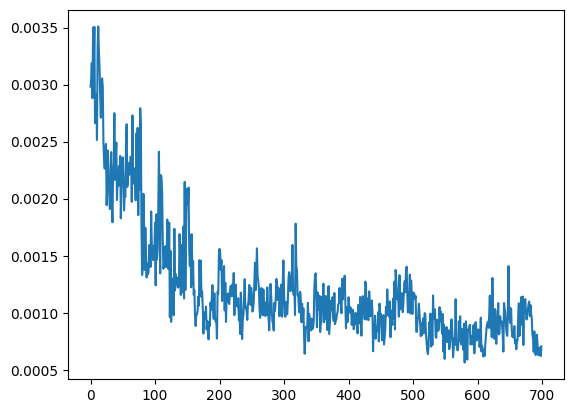

In [83]:
#Loss function
sigma = median_heuristic(plano) /3 #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(n_qubits))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(plano), # samples from ground truth distribution
    "sigma": sigma,
    "n_ops": 2000,
    "n_samples": 2000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.01)
trainer.train(n_iters= 700,loss_kwargs=loss_kwarg)
trained_params = trainer.final_params
plt.plot(trainer.losses)
plt.show() 

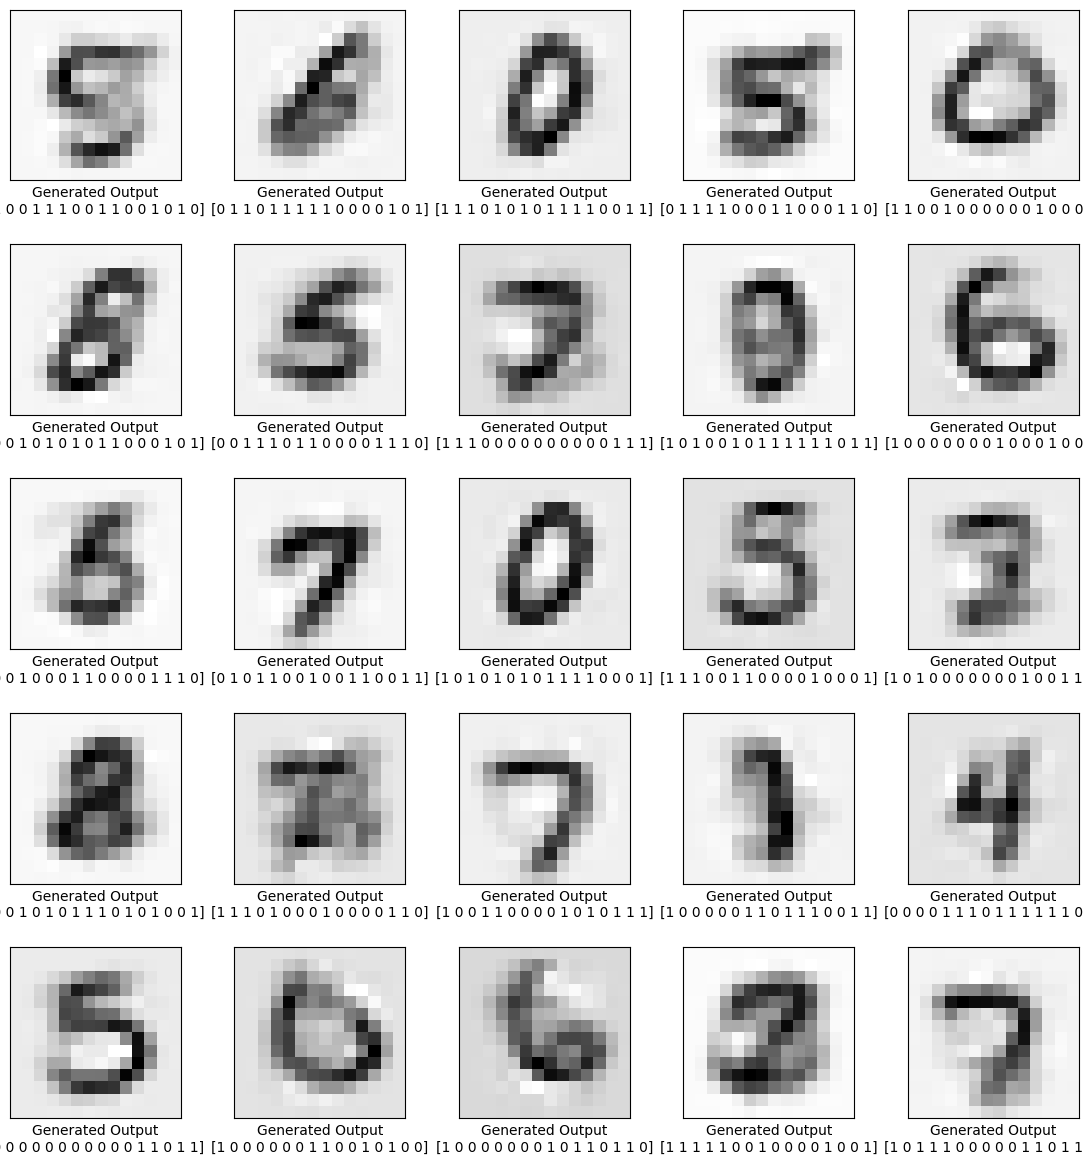

In [84]:
j = 1
plt.figure(figsize=[12, 12])
for i in range(25):
    ax = plt.subplot(5, 5, j)
    j += 1
    samp = circ.sample(trained_params,shots=1)
    generated = generate_from_latent(binary_vae, params, samp, (14,14,1), False)
    plt.imshow(generated, cmap="gray_r")
    plt.xlabel(f"Generated Output\n{samp}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=2.0)

## Sacar numeros: condicionada

Hay que definir una funcion que tome las label y los elementos y lo transforme todo junto

In [16]:
def labeled_data(train,label):
    label_bin = bin(label)[2:]
    label_list = [int(digito) for digito in label_bin.zfill(1)]
    return label_list + train.tolist()

In [26]:
#Transformar dataset
labeled = []
#Añadir un filtro
for k in range(len(plano)):
    if labels_plano[k] in [0,1]:
        labeled.append(labeled_data(plano[k],labels_plano[k]))



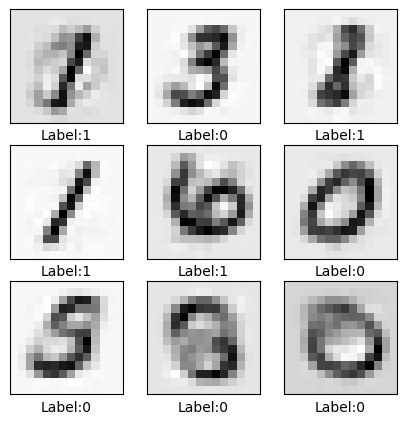

In [18]:
#Comprobar a ver que pasa
j = 1
plt.figure(figsize=[5, 5])
for i in labeled[:9]:
    ax = plt.subplot(3, 3, j)
    j += 1
    generated = generate_from_latent(binary_vae, params, i[1:], (14,14,1), False)
    plt.imshow(generated, cmap="gray_r")
    plt.xlabel(f'Label:{i[0]}')
    plt.xticks([])
    plt.yticks([])

In [153]:
#Circuito condicionado

n_qubits = 17 #4 decision + 20
depth = 50

cgates = []
for d in range(depth):
    cgates.append([[0]])
    for k in range(n_qubits - 1):
        cgates.append([[k+1]])
        cgates.append([[0,k+1]])
        cgates.append([[0,k+1],[k+1]])


lab_circ = iqp.IqpSimulator(n_qubits,cgates,device ='lightning.qubit')

2.8284271247461903


Training Progress: 100%|██████████| 500/500 [05:03<00:00,  1.64it/s, loss=0.005634, elapsed time=0.69, total time=305] 

Training has not converged after 500 steps


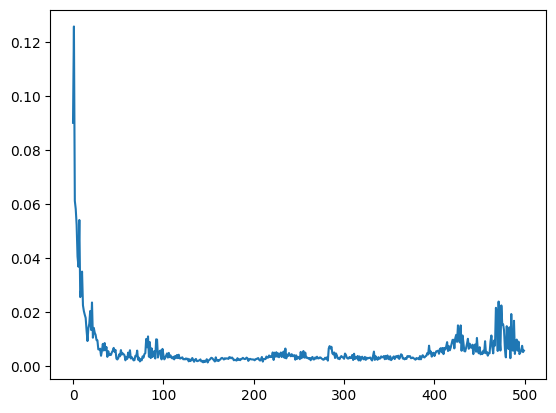

In [154]:
#Loss function
sigma = median_heuristic(labeled)   #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
params_init = jax.random.normal(key, (len(cgates),)) * (1 / jnp.sqrt(n_qubits))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": lab_circ,
    "ground_truth": jnp.array(labeled), # samples from ground truth distribution
    "sigma": sigma,
    "n_ops": 2000,
    "n_samples": 2000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.01)
trainer.train(n_iters= 500,loss_kwargs=loss_kwarg)
lab_trained_params = trainer.final_params
plt.plot(trainer.losses)
plt.show() 

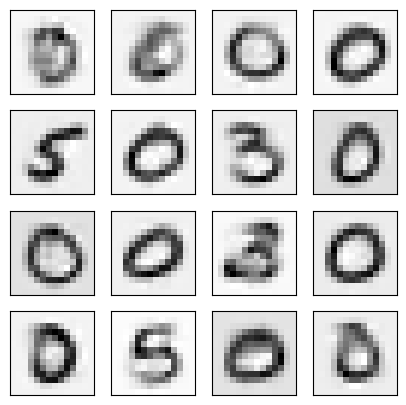

In [157]:
j = 1
plt.figure(figsize=[5, 5])
for i in range(16):
    if i % 2 == 0:
        samp = lab_circ.sample(lab_trained_params,shots=1)
    else:
        circ = iqp.IqpSimulator(n_qubits,cgates,init_gates=[[[0]]],init_coefs=[np.pi],device ='lightning.qubit')
        samp = circ.sample(lab_trained_params,shots=1)
    generated = generate_from_latent(binary_vae, params, samp[1:], (14,14,1), False)
    ax = plt.subplot(4, 4, j)
    j += 1
    plt.imshow(generated, cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


IDEA: Funcion ask_for_number() que samplee el circuito y devuelva el grafico representado con el numero pedido

In [156]:
def ask_for_numbers(selection,gates,params):
    str_gates = bin(selection)[2:].zfill(4)
    coefs =[np.pi * float(i) for i in str_gates]
    circ = iqp.IqpSimulator(17,gates,init_gates=[[[0]],[[1]],[[2]],[[3]]],init_coefs=coefs,device ='lightning.qubit')
    samp = circ.sample(params,shots=1)
    return samp


In [1]:
from datasets.three_qubit_entanglement import generate_bs1_state, schmidt_decomp



In [3]:
generate_bs1_state()

ValueError: cannot reshape array of size 2 into shape (2,2)

IDEA PARA CODIFICACION: Codificar a traves de puertas init, con puerts que añadimos antes del circuito IQP y donde ponemos el numero que queremos ¿Problema? Hay que entrenar modificando los parametros de estas puertas decisión y hay que entrenar conociendo las labels